# Artigo de Pós-Graduação PUCRS

### Machine Learning.

In [1]:
import pandas as pd
import datetime
import glob
from minio import Minio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

### Baixando o Dataset do Data Lake.

In [15]:
client.fget_object(
            "processing",
            "employeesDataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")
df = df[['Department', 'DaysLateLast30', 'Absences',
       'EmpSatisfaction', 'EngagementSurvey', 'PerformanceScore',
       'Termd']]

client.fget_object(
            "processing",
            "departmentSalaryTermd.parquet",
            "temp_.parquet",
)
dfSalary = pd.read_parquet("temp_.parquet")
dfSalary = dfSalary[['SalaryLevel']]

client.fget_object(
            "processing",
            "timeInCompany.parquet",
            "temp_.parquet",
)
dftimeInCompany = pd.read_parquet("temp_.parquet")
dftimeInCompany = dftimeInCompany[['TimeInCompany']]

client.fget_object(
            "processing",
            "numberSpecialProjects.parquet",
            "temp_.parquet",
)
dfNumberSpecialProjects = pd.read_parquet("temp_.parquet")
dfNumberSpecialProjects = dfNumberSpecialProjects[['SpecialProjectsCount']]

client.fget_object(
            "processing",
            "employeePerformanceEvaluation.parquet",
            "temp_.parquet",
)
dfPerfScoreFullyMeets = pd.read_parquet("temp_.parquet")
dfPerfScoreFullyMeets = dfPerfScoreFullyMeets[['perfScoreSatisfaction']]


df = pd.concat([df, dfSalary, dftimeInCompany, dfNumberSpecialProjects, dfPerfScoreFullyMeets], axis=1, join="inner")
df


,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0,False
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6,False
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0,False
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0,True
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0,False
...,...,...,...,...,...,...,...,...,...,...,...
306,Production,0,13,4,4.07,Fully Meets,0,medium,5,0,True
307,Production,5,4,2,3.20,PIP,1,low,8,0,False
308,IT/IS,0,16,5,4.60,Exceeds,0,high,9,6,False
309,IT/IS,0,11,3,5.00,Fully Meets,0,high,4,5,True


In [16]:
df.groupby(["perfScoreSatisfaction"])["perfScoreSatisfaction"].count()

perfScoreSatisfaction
False    143
True     168
Name: perfScoreSatisfaction, dtype: int64

#### Verificando os registros missing.

In [4]:
df.isnull().sum()

Department              0
DaysLateLast30          0
Absences                0
EmpSatisfaction         0
EngagementSurvey        0
PerformanceScore        0
Termd                   0
SalaryLevel             0
TimeInCompany           0
SpecialProjectsCount    0
dtype: int64

In [5]:
df[df.notnull()]

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0
...,...,...,...,...,...,...,...,...,...,...
306,Production,0,13,4,4.07,Fully Meets,0,medium,5,0
307,Production,5,4,2,3.20,PIP,1,low,8,0
308,IT/IS,0,16,5,4.60,Exceeds,0,high,9,6
309,IT/IS,0,11,3,5.00,Fully Meets,0,high,4,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Department            311 non-null    object 
 1   DaysLateLast30        311 non-null    int64  
 2   Absences              311 non-null    int64  
 3   EmpSatisfaction       311 non-null    int64  
 4   EngagementSurvey      311 non-null    float64
 5   PerformanceScore      311 non-null    object 
 6   Termd                 311 non-null    int64  
 7   SalaryLevel           311 non-null    object 
 8   TimeInCompany         311 non-null    int64  
 9   SpecialProjectsCount  311 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 24.4+ KB


###  Importancia de Features

#### Converte os atributos em categoricos.

In [7]:
df.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0


In [8]:
df["Department"] = df["Department"].astype('category').cat.codes
df["SalaryLevel"] = df["SalaryLevel"].astype('category').cat.codes
df["EmpSatisfaction"] = df["EmpSatisfaction"].astype('category').cat.codes
df["PerformanceScore"] = df["PerformanceScore"].astype('category').cat.codes
df["Termd"] = df["Termd"].astype('category').cat.codes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Department            311 non-null    int8   
 1   DaysLateLast30        311 non-null    int64  
 2   Absences              311 non-null    int64  
 3   EmpSatisfaction       311 non-null    int8   
 4   EngagementSurvey      311 non-null    float64
 5   PerformanceScore      311 non-null    int8   
 6   Termd                 311 non-null    int8   
 7   SalaryLevel           311 non-null    int8   
 8   TimeInCompany         311 non-null    int64  
 9   SpecialProjectsCount  311 non-null    int64  
dtypes: float64(1), int64(4), int8(5)
memory usage: 13.8 KB


In [9]:
df.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount
0,3,0,1,4,4.60,0,0,2,8,0
1,2,0,17,2,4.96,1,1,0,2,6
2,3,0,3,2,3.02,1,1,2,2,0
3,3,0,15,4,4.84,1,0,2,11,0
4,3,0,2,3,5.00,1,1,1,6,0


#### Separando os conjuntos de dados.

In [10]:
perfScoreSatisfaction
target_name = 'Termd'
X = df.drop('Termd', axis=1)
y = df[target_name]

#### Transformando os dados.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.6       , 0.        , 0.        , ..., 1.        , 0.58333333,
        0.        ],
       [0.4       , 0.        , 0.84210526, ..., 0.        , 0.08333333,
        0.75      ],
       [0.6       , 0.        , 0.10526316, ..., 1.        , 0.08333333,
        0.        ],
       ...,
       [0.4       , 0.        , 0.78947368, ..., 0.        , 0.66666667,
        0.75      ],
       [0.4       , 0.        , 0.52631579, ..., 0.        , 0.25      ,
        0.625     ],
       [0.6       , 0.        , 0.05263158, ..., 0.5       , 0.33333333,
        0.        ]])

#### Separando os conjuntos.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

#### Treinando o algoritmo de arvore de decisão.

In [13]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)

importances = dtree.feature_importances_
feat_names = df.drop(['Termd'],axis=1).columns

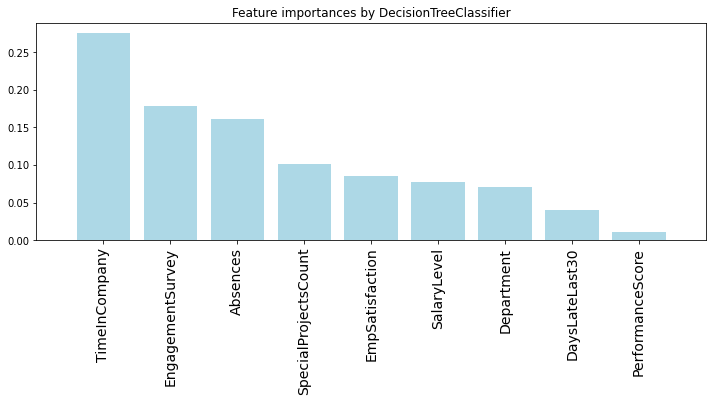

In [14]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Filtrando apenas os atributos relevantes.

In [15]:
df.columns

Index(['Department', 'DaysLateLast30', 'Absences', 'EmpSatisfaction',
       'EngagementSurvey', 'PerformanceScore', 'Termd', 'SalaryLevel',
       'TimeInCompany', 'SpecialProjectsCount'],
      dtype='object')

In [16]:
X = df[["TimeInCompany","EngagementSurvey","Absences","SpecialProjectsCount"]]

#### Separando os conjuntos de dados.

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

X_train

array([[0.08333333, 1.        , 0.52631579, 0.625     ],
       [0.58333333, 0.53092784, 0.78947368, 0.        ],
       [0.16666667, 0.76804124, 0.05263158, 0.875     ],
       [0.41666667, 0.7371134 , 0.        , 0.        ],
       [0.5       , 0.94845361, 0.15789474, 0.        ],
       [0.41666667, 0.76804124, 0.52631579, 0.        ],
       [0.58333333, 0.87113402, 0.        , 0.        ],
       [0.16666667, 0.81958763, 0.94736842, 0.        ],
       [0.41666667, 0.61340206, 0.84210526, 0.        ],
       [0.16666667, 0.3814433 , 0.15789474, 0.        ],
       [0.25      , 0.83505155, 0.47368421, 0.        ],
       [0.25      , 1.        , 0.78947368, 0.        ],
       [0.33333333, 0.81958763, 0.15789474, 0.        ],
       [0.5       , 0.7242268 , 0.10526316, 0.        ],
       [0.25      , 0.22680412, 0.31578947, 0.        ],
       [0.08333333, 0.59278351, 0.84210526, 0.875     ],
       [0.16666667, 0.76804124, 1.        , 0.        ],
       [0.25      , 1.        ,

#### Função do modelo de base.

In [18]:
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

#### Importando métodos de métrica de avaliação.

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [20]:
def accuracy_result(y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print ("Accuracy = %2.2f" % acc)

In [21]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [22]:
y_predict = base_rate_model(X_test)

accuracy_result(y_test, y_predict)

Accuracy = 0.67


In [23]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        42
           1       0.00      0.00      0.00        21

    accuracy                           0.67        63
   macro avg       0.33      0.50      0.40        63
weighted avg       0.44      0.67      0.53        63



/Users/san/Documents/GitHub/Artigo_PUCRS_CD_IA/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/san/Documents/GitHub/Artigo_PUCRS_CD_IA/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/san/Documents/GitHub/Artigo_PUCRS_CD_IA/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

### Modelo de Regressão Logística.

#### Instânciando o algoritmo.

In [24]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression()

#### Realizando o treinamento.

In [25]:
logis.fit(X_train, y_train)

LogisticRegression()

#### Calculando as predições.

In [26]:
y_predict = logis.predict(X_test)

#### Avaliando o resultado.

In [27]:
accuracy_result(y_test, y_predict)

Accuracy = 0.79


In [28]:
roc_classification_report_results("Logistic Regression", y_test, y_predict)


Logistic Regression AUC = 0.6904761904761905

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        42
           1       1.00      0.38      0.55        21

    accuracy                           0.79        63
   macro avg       0.88      0.69      0.71        63
weighted avg       0.84      0.79      0.76        63



### Modelo de Arvore de decisão.

#### Instânciando o algoritmo.

In [29]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [30]:
dtree = dtree.fit(X_train,y_train)

#### Calculando as predições.

In [31]:
y_predict = dtree.predict(X_test)

#### Avaliando o resultado.

In [32]:
accuracy_result(y_test, y_predict)

Accuracy = 0.56


In [33]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.5

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        42
           1       0.33      0.33      0.33        21

    accuracy                           0.56        63
   macro avg       0.50      0.50      0.50        63
weighted avg       0.56      0.56      0.56        63



### Modelo de Arvore Aleatória (Random Forest)

#### Instânciando o algoritmo.

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

#### Realizando o treinamento.

In [35]:
rf = rf.fit(X_train,y_train)

#### Calculando as predições.

In [36]:
y_predict = rf.predict(X_test)

#### Avaliando o resultado.

In [37]:
accuracy_result(y_test, y_predict)

Accuracy = 0.63


In [38]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.5476190476190476

              precision    recall  f1-score   support

           0       0.69      0.81      0.75        42
           1       0.43      0.29      0.34        21

    accuracy                           0.63        63
   macro avg       0.56      0.55      0.55        63
weighted avg       0.61      0.63      0.61        63



### Pycaret

#### Importando os métodos.

In [39]:
from pycaret.classification import *

In [40]:
df.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount
0,3,0,1,4,4.60,0,0,2,8,0
1,2,0,17,2,4.96,1,1,0,2,6
2,3,0,3,2,3.02,1,1,2,2,0
3,3,0,15,4,4.84,1,0,2,11,0
4,3,0,2,3,5.00,1,1,1,6,0


#### Definindo o Setup.

In [43]:
s = setup( df[['Department', 'DaysLateLast30', 'Absences', 'EmpSatisfaction',
       'EngagementSurvey', 'PerformanceScore', 'Termd', 'SalaryLevel',
       'TimeInCompany', 'SpecialProjectsCount']]
          ,target = "PerformanceScore"
          ,numeric_features = ["TimeInCompany"]
          ,normalize = True
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )

,Description,Value
0,Session id,8119
1,Target,PerformanceScore
2,Target type,Multiclass
3,Original data shape,"(311, 10)"
4,Transformed data shape,"(770, 10)"
5,Transformed train set shape,"(676, 10)"
6,Transformed test set shape,"(94, 10)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


#### Comparando diferentes modelos.

In [44]:
best = compare_models(fold = 5,sort = 'AUC',)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7696,0.7805,0.7696,0.7779,0.7650,0.3788,0.3866,0.0820
lda,Linear Discriminant Analysis,0.5942,0.7675,0.5942,0.7923,0.6485,0.2540,0.3007,0.0120
nb,Naive Bayes,0.2488,0.7627,0.2488,0.7980,0.2188,0.0951,0.2272,0.1480
lr,Logistic Regression,0.5756,0.7552,0.5756,0.7718,0.6273,0.2312,0.2741,0.6340
et,Extra Trees Classifier,0.7650,0.7496,0.7650,0.7389,0.7417,0.3310,0.3417,0.0340
lightgbm,Light Gradient Boosting Machine,0.7603,0.7413,0.7603,0.7628,0.7518,0.3509,0.3611,0.0400
rf,Random Forest Classifier,0.8158,0.7411,0.8158,0.7827,0.7911,0.4592,0.4770,0.0360
knn,K Neighbors Classifier,0.5943,0.7000,0.5943,0.7625,0.6452,0.2181,0.2534,0.1640
ada,Ada Boost Classifier,0.6900,0.6699,0.6900,0.7293,0.6684,0.3239,0.3641,0.0240
dt,Decision Tree Classifier,0.6728,0.6558,0.6728,0.7414,0.6942,0.2515,0.2618,0.0100


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

#### Criando o modelo.

In [45]:
gbc = create_model('gbc', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7955,0.7549,0.7955,0.7492,0.7573,0.3664,0.3845
1,0.7500,0.7779,0.7500,0.7351,0.7422,0.3144,0.3152
2,0.7674,0.8456,0.7674,0.8194,0.7762,0.4487,0.4543
3,0.7674,0.7477,0.7674,0.7553,0.7558,0.3185,0.3199
4,0.7674,0.7763,0.7674,0.8305,0.7934,0.4459,0.4593
Mean,0.7696,0.7805,0.7696,0.7779,0.7650,0.3788,0.3866
Std,0.0146,0.0346,0.0146,0.0391,0.0179,0.0588,0.0623


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#### Realizando o tunning do modelo.

In [46]:
tuned_gbc = tune_model(gbc
                      ,fold = 5
                      ,custom_grid = {"learning_rate":[0.1,0.2,0.5]
                                     ,"n_estimators":[100,500,1000]
                                     ,"min_samples_split":[1,2,5,10]
                                     ,"max_depth":[1,3,9]
                                     }
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.7581,0.8182,0.8047,0.7954,0.4618,0.4736
1,0.7500,0.7836,0.7500,0.7235,0.7320,0.2882,0.2915
2,0.6279,0.8097,0.6279,0.7198,0.6659,0.2028,0.2111
3,0.7442,0.7993,0.7442,0.7665,0.7480,0.3668,0.3752
4,0.8140,0.8363,0.8140,0.8591,0.8292,0.5584,0.5734
Mean,0.7508,0.7974,0.7508,0.7747,0.7541,0.3756,0.3850
Std,0.0688,0.0261,0.0688,0.0524,0.0560,0.1252,0.1284


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


#### Finalizando o modelo.

In [47]:
final_model = finalize_model(tuned_gbc)
save_model(final_model,'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/var/folders/mj/jgp1syh15f353pj12fcfnzyc0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['TimeInCompany'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(ex...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.5, loss='log_loss',
                                             max_depth=1

#### Transferindo os arquivos para o Data Lake.

#### Modelo de Classificação.

In [48]:
client.fput_object(
    "curated",
    "model.pkl",
    "model.pkl"
)

#### Exportando o conjunto de dados para o disco.

In [49]:
df.to_csv("dataset.csv",index=False)

In [50]:
client.fput_object(
    "curated",
    "dataset.csv",
    "dataset.csv"
)